In [1]:
import pandas as pd
from dfply import *
from more_dfply import *
pd.set_option("display.max_colwidth", None) # don't cut off text
pd.set_option("display.max_columns", None) # horizontal scroll columns instead of wrapping around

In [2]:
crosswalk = pd.read_csv("./data/CMS_Facility_to_FIPS_Crosswalk.csv")
hospital = pd.read_csv("./data/Timely_and_Effective_Care-Hospital.csv")
poverty = pd.read_csv("./data/PovertyEstimates.csv")

hospital.columns = hospital.columns.str.replace(' ', '_')
crosswalk.columns = crosswalk.columns.str.replace(' ', '_')

hospital

,Facility_ID,Facility_Name,Address,City,State,ZIP_Code,County_Name,Phone_Number,Condition,Measure_ID,Measure_Name,Score,Sample,Footnote,Start_Date,End_Date
0,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Emergency Department,EDV,Emergency department volume,high,NaN,NaN,01/01/2020,12/31/2020
1,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Preventive Care,IMM_3,Healthcare workers given influenza vaccination,99,4119,NaN,10/01/2020,03/31/2021
2,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Emergency Department,OP_18b,Average (median) time patients spent in the emergency department before leaving from the visit A lower number of minutes is better,224,314,NaN,10/01/2020,09/30/2021
3,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Emergency Department,OP_18c,Average (median) time patients spent in the emergency department before leaving from the visit- Psychiatric/Mental Health Patients. A lower number of minutes is better,207,11,NaN,10/01/2020,09/30/2021
4,010001,SOUTHEAST HEALTH MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,(334) 793-8701,Heart Attack or Chest Pain,OP_2,Fibrinolytic Therapy Received Within 30 Minutes of ED Arrival,Not Available,Not Available,5,10/01/2020,09/30/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75292,670314,ST MICHAELS MEDICAL HOSPITAL LLC,"16000 SOUTHWEST FREEWAY, SUITE 100",SUGAR LAND,TX,77479,FORT BEND,(281) 980-4357,Sepsis Care,SEP_1,Appropriate care for severe sepsis and septic shock,Not Available,Not Available,5,10/01/2020,09/30/2021
75293,670314,ST MICHAELS MEDICAL HOSPITAL LLC,"16000 SOUTHWEST FREEWAY, SUITE 100",SUGAR LAND,TX,77479,FORT BEND,(281) 980-4357,Sepsis Care,SEP_SH_3HR,Septic Shock 3-Hour Bundle,Not Available,Not Available,5,10/01/2020,09/30/2021
75294,670314,ST MICHAELS MEDICAL HOSPITAL LLC,"16000 SOUTHWEST FREEWAY, SUITE 100",SUGAR LAND,TX,77479,FORT BEND,(281) 980-4357,Sepsis Care,SEP_SH_6HR,Septic Shock 6-Hour Bundle,Not Available,Not Available,5,10/01/2020,09/30/2021
75295,670314,ST MICHAELS MEDICAL HOSPITAL LLC,"16000 SOUTHWEST FREEWAY, SUITE 100",SUGAR LAND,TX,77479,FORT BEND,(281) 980-4357,Sepsis Care,SEV_SEP_3HR,Severe Sepsis 3-Hour Bundle,Not Available,Not Available,5,10/01/2020,09/30/2021


In [3]:
hospital_clean = (hospital
                  >> select(X.Facility_ID,X.State,X.County_Name,X.Condition, X.Measure_Name, X.Score)
                  >> filter_by(X.Condition == 'Emergency Department')
                  >> filter_by(~X.Measure_Name.str.contains('Psychiatric|CT'))
                  >> select(~X.Condition)
                  >> mutate(Score = if_else(X.Score == 'Not Available', np.nan, X.Score))
                  >> spread(X.Measure_Name,X.Score)
                  )

hospital_clean.rename(columns={hospital_clean.columns[3]: 'Avg_Median_Time_in_ER'}, inplace=True)

hospital_clean.columns = hospital_clean.columns.str.replace(' ', '_')
hospital_clean

,Facility_ID,State,County_Name,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen
0,010001,AL,HOUSTON,224,high,2
1,010005,AL,MARSHALL,146,high,2
2,010006,AL,LAUDERDALE,166,medium,2
3,010007,AL,COVINGTON,121,low,5
4,010008,AL,CRENSHAW,118,low,0
...,...,...,...,...,...,...
4701,670280,TX,HARRIS,nan,nan,nan
4702,670285,TX,HARRIS,nan,nan,nan
4703,670300,TX,ELLIS,134,nan,nan
4704,670309,TX,TARRANT,158,nan,nan


In [4]:
#Double checking counts with Tableau prep
(hospital_clean
 >> group_by(X.Emergency_department_volume)
 >> summarise(Count = n(X.Emergency_department_volume))
)

,Emergency_department_volume,Count
0,high,515
1,low,1704
2,medium,960
3,nan,1078
4,very high,449


In [5]:
#Got below error message in try1 of left_join:
    #ValueError: You are trying to merge on object and float64 columns. If you wish to proceed you should use pd.concat
    #Therefore, gotta double normalize the types
        #hospital_clean['Facility ID'] = hospital_clean['Facility ID'].astype(float)
        #crosswalk['Facility ID'] = crosswalk['Facility ID'].astype(float)

#Got below error message in try1 of making hospital_clean['Facility ID'].astype(float)
    #ValueError: could not convert string to float: '02013F'

#Turns out there are a couple of facilities with IDs that are not entirely numeric 
(hospital_clean
  >> filter_by(X.Facility_ID.str.contains('\D'))
)

,Facility_ID,State,County_Name,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen
97,02013F,AK,ANCHORAGE,98,low,0
98,02014F,AK,FAIRBANKS NORTH STAR,168,low,0
351,05015F,CA,SOLANO,125,nan,nan
364,05020F,CA,SAN DIEGO,130,low,0
370,05022F,CA,SAN DIEGO,147,medium,0
432,05039F,CA,SAN BERNARDINO,124,low,0
437,05041F,CA,SAN BERNARDINO,nan,low,0
623,06003F,CO,EL PASO,154,low,2
809,10013F,FL,DUVAL,128,medium,0
840,10021F,FL,OKALOOSA,83,nan,nan


In [6]:
#After checking how Tableau Prep dealt with the cases above, we'll make them NAs
hospital_clean = (hospital_clean
                  >> mutate(Facility_ID = if_else(X.Facility_ID.str.contains('\D'), np.nan, X.Facility_ID))
                 )

In [7]:
#Try2 on normalizing types for left_join:
hospital_clean.Facility_ID = hospital_clean.Facility_ID.astype(float)
crosswalk.Facility_ID = crosswalk['Facility_ID'].astype(float)

In [8]:
#Joining hospital data with their respective FIPs
hospital_w_FIPS = hospital_clean >> left_join(crosswalk, by='Facility_ID')
hospital_w_FIPS

,Facility_ID,State_x,County_Name_x,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen,State_y,County_Name_y,FIPS
0,10001.0,AL,HOUSTON,224,high,2,AL,HOUSTON,1069.0
1,10005.0,AL,MARSHALL,146,high,2,AL,MARSHALL,1095.0
2,10006.0,AL,LAUDERDALE,166,medium,2,AL,LAUDERDALE,1077.0
3,10007.0,AL,COVINGTON,121,low,5,AL,COVINGTON,1039.0
4,10008.0,AL,CRENSHAW,118,low,0,AL,CRENSHAW,1041.0
...,...,...,...,...,...,...,...,...,...
5891,670280.0,TX,HARRIS,nan,nan,nan,TX,HARRIS,48201.0
5892,670285.0,TX,HARRIS,nan,nan,nan,TX,HARRIS,48201.0
5893,670300.0,TX,ELLIS,134,nan,nan,TX,ELLIS,48139.0
5894,670309.0,TX,TARRANT,158,nan,nan,TX,TARRANT,48439.0


In [9]:
hospital_w_FIPS.rename(columns={'State_x': 'State', 'County_Name_x' : 'County_Name'}, inplace=True)

hospital_w_FIPS_clean = (hospital_w_FIPS
                         >> select(~X.State_y, ~X.County_Name_y)
                        )
hospital_w_FIPS_clean

,Facility_ID,State,County_Name,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen,FIPS
0,10001.0,AL,HOUSTON,224,high,2,1069.0
1,10005.0,AL,MARSHALL,146,high,2,1095.0
2,10006.0,AL,LAUDERDALE,166,medium,2,1077.0
3,10007.0,AL,COVINGTON,121,low,5,1039.0
4,10008.0,AL,CRENSHAW,118,low,0,1041.0
...,...,...,...,...,...,...,...
5891,670280.0,TX,HARRIS,nan,nan,nan,48201.0
5892,670285.0,TX,HARRIS,nan,nan,nan,48201.0
5893,670300.0,TX,ELLIS,134,nan,nan,48139.0
5894,670309.0,TX,TARRANT,158,nan,nan,48439.0


In [10]:
poverty.rename(columns={'FIPStxt': 'FIPS'}, inplace = True) #This will allow the join below

poverty_clean = (poverty
                 >> filter_by(X.Attribute == 'PCTPOVALL_2020')
                 >> spread(X.Attribute,X.Value)
                 >> select(X.FIPS, X.PCTPOVALL_2020)
                )

poverty_clean

,FIPS,PCTPOVALL_2020
0,0,11.9
1,1000,14.9
2,1001,11.2
3,1003,8.9
4,1005,25.5
...,...,...
3189,56037,7.6
3190,56039,5.2
3191,56041,8.5
3192,56043,9.7


In [11]:
#Joining hospital_w_FIPS with poverty
hospital_w_FIPS_n_poverty = hospital_w_FIPS_clean >> left_join(poverty_clean, by='FIPS')
hospital_w_FIPS_n_poverty

,Facility_ID,State,County_Name,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen,FIPS,PCTPOVALL_2020
0,10001.0,AL,HOUSTON,224,high,2,1069.0,14.8
1,10005.0,AL,MARSHALL,146,high,2,1095.0,15.4
2,10006.0,AL,LAUDERDALE,166,medium,2,1077.0,13.9
3,10007.0,AL,COVINGTON,121,low,5,1039.0,17.1
4,10008.0,AL,CRENSHAW,118,low,0,1041.0,16.8
...,...,...,...,...,...,...,...,...
5891,670280.0,TX,HARRIS,nan,nan,nan,48201.0,15.9
5892,670285.0,TX,HARRIS,nan,nan,nan,48201.0,15.9
5893,670300.0,TX,ELLIS,134,nan,nan,48139.0,7.9
5894,670309.0,TX,TARRANT,158,nan,nan,48439.0,10.5


In [12]:
hospital_w_FIPS_n_poverty.Avg_Median_Time_in_ER = hospital_w_FIPS_n_poverty.Avg_Median_Time_in_ER.astype(float)
hospital_w_FIPS_n_poverty.Left_before_being_seen = hospital_w_FIPS_n_poverty.Left_before_being_seen.astype(float)
hospital_w_FIPS_n_poverty.PCTPOVALL_2020 = hospital_w_FIPS_n_poverty.PCTPOVALL_2020.astype(float)

In [13]:
AVG_Time_in_ER_and_Poverty = (hospital_w_FIPS_n_poverty
                               >> group_by(X.PCTPOVALL_2020)
                               >> summarise(AVG_of_Avg_Median_Time_in_ER = mean(X.Avg_Median_Time_in_ER))
                             )
AVG_Time_in_ER_and_Poverty

,PCTPOVALL_2020,AVG_of_Avg_Median_Time_in_ER
0,3.0,166.5
1,3.2,140.5
2,3.3,138.0
3,3.5,168.0
4,3.7,143.0
...,...,...
254,37.3,131.0
255,37.6,92.0
256,38.2,105.0
257,39.6,169.0


In [16]:
import numpy
import geopandas
import pysal
import seaborn as sns
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

<AxesSubplot:xlabel='PCTPOVALL_2020', ylabel='AVG_of_Avg_Median_Time_in_ER'>

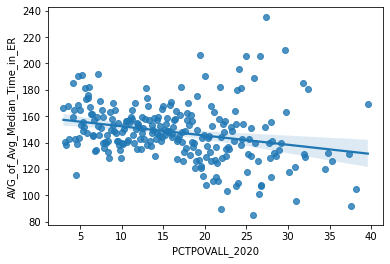

In [17]:
g = sns.regplot(data=AVG_Time_in_ER_and_Poverty,
                    x="PCTPOVALL_2020",
                    y="AVG_of_Avg_Median_Time_in_ER",
                   )
g

In [18]:
AVG_Left_before_being_seen_and_Poverty = (hospital_w_FIPS_n_poverty
                                          >> group_by(X.PCTPOVALL_2020)
                                          >> summarise(AVG_Left_before_being_seen = mean(X.Left_before_being_seen))
                                         )
AVG_Left_before_being_seen_and_Poverty

,PCTPOVALL_2020,AVG_Left_before_being_seen
0,3.0,0.75
1,3.2,0.00
2,3.3,1.00
3,3.5,1.00
4,3.7,1.00
...,...,...
254,37.3,1.00
255,37.6,NaN
256,38.2,2.00
257,39.6,6.00


<AxesSubplot:xlabel='PCTPOVALL_2020', ylabel='AVG_Left_before_being_seen'>

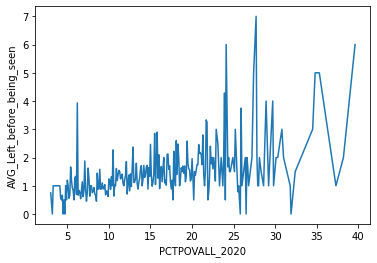

In [19]:
g = sns.lineplot(data=AVG_Left_before_being_seen_and_Poverty,
                    x="PCTPOVALL_2020",
                    y="AVG_Left_before_being_seen",
                   )
g

In [21]:
CTN_Emergency_department_volume_and_Poverty = (hospital_w_FIPS_n_poverty
                                               >> group_by(X.Emergency_department_volume)
                                               >> summarise(Count = n(X.Emergency_department_volume))
                                              )
CTN_Emergency_department_volume_and_Poverty

,Emergency_department_volume,Count
0,high,549
1,low,2486
2,medium,1130
3,nan,1282
4,very high,449


<AxesSubplot:xlabel='Emergency_department_volume', ylabel='Count'>

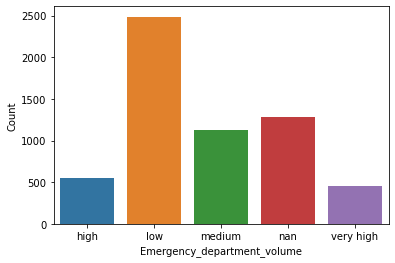

In [22]:
g = sns.barplot(data=CTN_Emergency_department_volume_and_Poverty,
                    x="Emergency_department_volume",
                    y="Count",
                   )
g

In [23]:
County_lat_long = pd.read_csv("./data/County_Lat_Long.csv", names = ['County_Name', 'State','Latitude','Longitude'], header =0) #Exported file from generated lat and long from Tableau
County_lat_long

,County_Name,State,Latitude,Longitude
0,WESTON,WY,43.8403,-104.5684
1,WASHAKIE,WY,43.8356,-107.6602
2,UINTA,WY,41.3156,-110.5477
3,TETON,WY,43.9385,-110.5501
4,SWEETWATER,WY,41.6405,-108.9887
...,...,...,...,...
2470,JUNEAU,AK,58.3893,-134.4110
2471,FAIRBANKS NORTH STAR,AK,64.8624,-146.3565
2472,DILLINGHAM,AK,59.7435,-158.1036
2473,BETHEL,AK,60.4765,-160.8218


In [24]:
#Joining hospital_w_FIPS with poverty
hospital_w_FIPS_n_poverty_geolocation = hospital_w_FIPS_n_poverty >> left_join(County_lat_long, by='County_Name')
hospital_w_FIPS_n_poverty_geolocation

,Facility_ID,State_x,County_Name,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen,FIPS,PCTPOVALL_2020,State_y,Latitude,Longitude
0,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,TX,31.2600,-95.4349
1,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,TN,36.2734,-87.7325
2,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,GA,32.4877,-83.6449
3,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,AL,31.1562,-85.2809
4,10005.0,AL,MARSHALL,146.0,high,2.0,1095.0,15.4,WV,39.8776,-80.6555
...,...,...,...,...,...,...,...,...,...,...,...
20953,670300.0,TX,ELLIS,134.0,nan,NaN,48139.0,7.9,TX,32.3014,-96.7619
20954,670300.0,TX,ELLIS,134.0,nan,NaN,48139.0,7.9,OK,36.2174,-99.7981
20955,670300.0,TX,ELLIS,134.0,nan,NaN,48139.0,7.9,KS,38.9163,-99.3172
20956,670309.0,TX,TARRANT,158.0,nan,NaN,48439.0,10.5,TX,32.7708,-97.2917


In [75]:
gdf = geopandas.GeoDataFrame(
    hospital_w_FIPS_n_poverty_geolocation, geometry=geopandas.points_from_xy(hospital_w_FIPS_n_poverty_geolocation.Longitude, hospital_w_FIPS_n_poverty_geolocation.Latitude))
gdf

,Facility_ID,State_x,County_Name,Avg_Median_Time_in_ER,Emergency_department_volume,Left_before_being_seen,FIPS,PCTPOVALL_2020,State_y,Latitude,Longitude,geometry
0,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,TX,31.2600,-95.4349,POINT (-95.43490 31.26000)
1,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,TN,36.2734,-87.7325,POINT (-87.73250 36.27340)
2,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,GA,32.4877,-83.6449,POINT (-83.64490 32.48770)
3,10001.0,AL,HOUSTON,224.0,high,2.0,1069.0,14.8,AL,31.1562,-85.2809,POINT (-85.28090 31.15620)
4,10005.0,AL,MARSHALL,146.0,high,2.0,1095.0,15.4,WV,39.8776,-80.6555,POINT (-80.65550 39.87760)
...,...,...,...,...,...,...,...,...,...,...,...,...
20953,670300.0,TX,ELLIS,134.0,nan,NaN,48139.0,7.9,TX,32.3014,-96.7619,POINT (-96.76190 32.30140)
20954,670300.0,TX,ELLIS,134.0,nan,NaN,48139.0,7.9,OK,36.2174,-99.7981,POINT (-99.79810 36.21740)
20955,670300.0,TX,ELLIS,134.0,nan,NaN,48139.0,7.9,KS,38.9163,-99.3172,POINT (-99.31720 38.91630)
20956,670309.0,TX,TARRANT,158.0,nan,NaN,48439.0,10.5,TX,32.7708,-97.2917,POINT (-97.29170 32.77080)


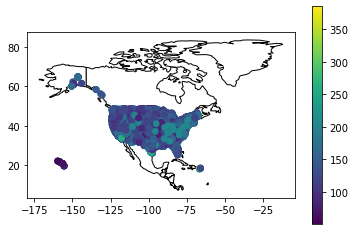

In [96]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot("Avg_Median_Time_in_ER",ax=ax, legend=True, figsize = (50,50))

plt.show()